This is a file meant to demonstrate the code developed by the group brAIn-Power in the course 02456 Deep learning 2021 for Deloitte. NOTE: as the data was confidential, it is not included. Since we were not able to gather replacement data, random data is generated in order for the code to run. This means all the outputs will be nonsense, however, the code is still demonstrated.The results we found using this code base with the data provided by Deloitte in shared in the final report.

Emilie Rasmussen - s213451,
Gary Fougerolle - s211974,
Mikkel Danielsen - s183913,
Oscar Carpentier - s201590,
Tyme Chatupanyachotikul - s212273

# Imports

In [1]:
!pip install import-ipynb
import cv2
import glob
import scipy
import import_ipynb
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import numpy.random
import random
import os
import platform
import sklearn.metrics
import torch
import torch.nn as nn
import torchvision
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
import time
from IPython.display import clear_output

# UNet

Inspired by https://github.com/kevinlu1211/pytorch-unet-resnet-50-encoder/blob/master/u_net_resnet_50_encoder.py

In [2]:
# Conv -> BN -> ReLU
class ConvBlock(nn.Module):

    def __init__(self, channels_in, channels_out, padding=1, kernel_size=3, stride=1, act_fct=nn.ReLU()):
        super().__init__()
        self.conv = nn.Conv2d(channels_in, channels_out, padding=padding, kernel_size=kernel_size, stride=stride)
        self.bn = nn.BatchNorm2d(channels_out)
        self.act_fct = act_fct
        self.dropout = nn.Dropout(0.3)

    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        x = self.act_fct(x)
        x = self.dropout(x)

        return x

In [3]:
# Middle layer of U-net
class Bridge(nn.Module):
    def __init__(self, channels_in, channels_out):
        super().__init__()
        self.max_pool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.conv1 = ConvBlock(channels_in, channels_out)
        self.conv2 = ConvBlock(channels_out, channels_out)

    def forward(self, x):
        x = self.max_pool(x)
        x = self.conv1(x)
        x = self.conv2(x)
        return x

In [4]:
# Middle layer of U-net (no max pooling)
class Bridge_no_pool(nn.Module):
    def __init__(self, channels_in, channels_out):
        super().__init__()
        self.conv1 = ConvBlock(channels_in, channels_out)
        self.conv2 = ConvBlock(channels_out, channels_out)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        return x

In [5]:
# Upsample -> Concatenate -> ConvBlock -> ConvBlock
class UpBlock(nn.Module):

    def __init__(self, channels_in, channels_out, up_channels_in=None, up_channels_out=None):
        super().__init__()

        if up_channels_in is None:
            up_channels_in = channels_in
        if up_channels_out is None:
            up_channels_out = channels_out

        # Double the resolution
        self.upsample = nn.ConvTranspose2d(up_channels_in, up_channels_out, kernel_size=2, stride=2)

        self.conv_block_1 = ConvBlock(channels_in, channels_out)
        self.conv_block_2 = ConvBlock(channels_out, channels_out)

    def forward(self, x_up, x_down):
        x = self.upsample(x_up)
        x = torch.cat([x, x_down], 1)
        x = self.conv_block_1(x)
        x = self.conv_block_2(x)
        return x

In [6]:
class UNet50(nn.Module):
    DEPTH = 6

    def __init__(self, n_classes,rgb=True):
        super().__init__()
        self.rgb = rgb
        resnet = torchvision.models.resnet.resnet50(pretrained=True)
        blocks_up = []
        blocks_down = []
        self.conv0 = torch.nn.Conv2d(1,3,1,1)
        self.input_block = nn.Sequential(*list(resnet.children()))[:3]
        self.input_pool = list(resnet.children())[3]
        
        for bottleneck in list(resnet.children()):
            if isinstance(bottleneck, nn.Sequential):
                blocks_down.append(bottleneck)
        self.blocks_down = nn.ModuleList(blocks_down)

        self.bridge = Bridge(2048, 4096)

        blocks_up.append(UpBlock(4096, 2048))
        blocks_up.append(UpBlock(2048, 1024))
        blocks_up.append(UpBlock(1024, 512))
        blocks_up.append(UpBlock(512, 256))
        blocks_up.append(UpBlock(channels_in=128 + 64, channels_out=128, up_channels_in=256, up_channels_out=128))
        blocks_up.append(UpBlock(channels_in=64 + 3, channels_out=64, up_channels_in=128, up_channels_out=64))
        self.blocks_up = nn.ModuleList(blocks_up)

        self.out = nn.Conv2d(64, n_classes, kernel_size=1, stride=1)

        self.softmax = nn.Softmax2d()

    def forward(self, x):
        if not self.rgb:
            x = self.conv0(x)
        pre_pools = dict()
        pre_pools[f"layer_0"] = x
        x = self.input_block(x)
        pre_pools[f"layer_1"] = x
        x = self.input_pool(x)

        for i, block in enumerate(self.blocks_down, 2):
            x = block(x)
            key = f"layer_{i}"
            pre_pools[key] = x

        x = self.bridge(x)

        for i, block in enumerate(self.blocks_up, 1):
            key = f"layer_{UNet50.DEPTH - i}"
            x = block(x, pre_pools[key])

        x = self.out(x)
        x = self.softmax(x)
        del pre_pools
        return x

In [7]:
class UNet18(nn.Module):
  DEPTH = 6

  def __init__(self, n_classes, rgb = True):
    super().__init__()
    
    blocks_up = []
    blocks_down = []
    resnet = torchvision.models.resnet.resnet18(pretrained=True)

    self.rgb = rgb
    self.conv0 = torch.nn.Conv2d(1,3,1,1)
    self.input_block = nn.Sequential(*list(resnet.children()))[:3]
    self.input_pool = list(resnet.children())[3]

    # Down blocks
    for bottleneck in list(resnet.children()):
      if isinstance(bottleneck, nn.Sequential):
        blocks_down.append(bottleneck)
    self.blocks_down = nn.ModuleList(blocks_down)

    # Bridge
    self.bridge = Bridge_no_pool(512, 512)

    # Up blocks
    blocks_up.append(UpBlock(512, 256))
    blocks_up.append(UpBlock(256, 128))
    blocks_up.append(UpBlock(128, 64))
    blocks_up.append(UpBlock(channels_in=128, channels_out=64, up_channels_in=64, up_channels_out=64))
    blocks_up.append(UpBlock(channels_in=64 + 3, channels_out=64, up_channels_in=64, up_channels_out=64))
    self.blocks_up = nn.ModuleList(blocks_up)

    self.out = nn.Conv2d(64, n_classes, kernel_size=1, stride=1)
    self.softmax = nn.Softmax2d()

  def forward(self, x):
    if not self.rgb:
      x = self.conv0(x)
    pre_pools = dict()
    pre_pools[f"layer_0"] = x
    x = self.input_block(x)
    pre_pools[f"layer_1"] = x
    x = self.input_pool(x)

    for i, block in enumerate(self.blocks_down, 2):
      x = block(x)
      key = f"layer_{i}"
      pre_pools[key] = x

    x = self.bridge(x)

    for i, block in enumerate(self.blocks_up, 1):
      key = f"layer_{UNet50.DEPTH - 1 - i}"
      x = block(x, pre_pools[key])

    x = self.out(x)
    x = self.softmax(x)
    del pre_pools
    return x
    

# Performance metric

In [8]:
class DiceLoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(DiceLoss, self).__init__()

    def forward(self, inputs, targets, smooth=1):
        # comment out if your model contains a sigmoid or equivalent activation layer
        inputs = torch.sigmoid(inputs)

        # flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)

        intersection = (inputs * targets).sum()
        dice = (2. * intersection + smooth) / (inputs.sum() + targets.sum() + smooth)

        return 1 - dice

In [9]:
def Dicecoeff(prediction,label):
  dice = 0
  for i in range(prediction.shape[0]):
    pred1 = one_hot_encode(np.argmax(prediction[i],axis=0))
    intersection = np.sum((pred1 * label[i]))
    dice += (2*intersection+1)/(pred1.sum()+label[i].sum()+1)
  
  return dice/prediction.shape[0]

In [10]:
ALPHA = 0.5  # < 0.5 penalises FP more, > 0.5 penalises FN more
CE_RATIO = 0.5  # weighted contribution of modified CE loss compared to Dice loss

class ComboLoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(ComboLoss, self).__init__()

    def forward(self, inputs, targets, smooth=1, ALPHA=ALPHA, CE_RATIO=CE_RATIO, eps=1e-9):
        # flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)

        # True Positives, False Positives & False Negatives
        intersection = (inputs * targets).sum()
        dice = (2. * intersection + smooth) / (inputs.sum() + targets.sum() + smooth)

        inputs = torch.clamp(inputs, eps, 1.0 - eps)
        out = - (ALPHA * ((targets * torch.log(inputs)) + ((1 - ALPHA) * (1.0 - targets) * torch.log(1.0 - inputs))))
        weighted_ce = out.mean(-1)
        combo = (CE_RATIO * weighted_ce) - ((1 - CE_RATIO) * dice)

        return combo

In [11]:
def IoU_score(target, prediction,threshold=0.9,special=False):
  ioulst = []
  correct = []
  for j in range(target.shape[0]):
    if special:
      tar1 = np.sum(target[j],axis=0).flatten()
    else:
      tar1 = one_hot2_2d(target[j])[0].flatten()
    pred1 = np.argmax(prediction[j],axis=0).flatten()

    iou = sklearn.metrics.jaccard_score(tar1,pred1,average='weighted')
    if iou>=threshold:
      correct.append(1)
    else:
      correct.append(0)

    ioulst.append(iou)
  return np.mean(ioulst),sum(correct)

In [12]:
def confidenceinterval(s):
    confidence_level = 0.95
    degrees_freedom = s.size - 1
    sample_mean = np.mean(s)
    sample_standard_error = scipy.stats.sem(s)
    confidence_interval = scipy.stats.t.interval(confidence_level, degrees_freedom, sample_mean, sample_standard_error)
    
    return confidence_interval

# Load data

In [13]:
def color_correction(img):
    img_new = np.zeros(img.shape)
    img_new[0,:,:] = img[0,:,:]+ 0.485 / 0.229
    img_new[1,:,:] = img[1,:,:] + 0.456 / 0.224
    img_new[2,:,:] = img[2,:,:]+ 0.406 / 0.225
    return img_new

In [14]:
def feature_scaling(img):
    img = (img - np.min(img)) / (-np.min(img) + np.max(img))
    return img

In [15]:
def scale(img, label):
    if img.shape[0] == 3:
        img = img.transpose([2, 1, 0])
        rows, cols, _ = img.shape
    else:
        rows, cols = img.shape

    if label.shape[0] == 9:
        label = one_hot2_2d(label)
    label = label[0]
    scaling_factor = random.uniform(0.9, 1.1)
    res = cv2.resize(img, (int(scaling_factor * rows), int(scaling_factor * cols)), interpolation=cv2.INTER_LINEAR)
    res_label = cv2.resize(label, (int(scaling_factor * rows), int(scaling_factor * cols)),
                           interpolation=cv2.INTER_LINEAR)
    newimg = np.zeros(img.shape)
    newlabel = np.zeros(label.shape)
    if res.shape[1] < newimg.shape[1]:
        newimg[0:res.shape[0], 0:res.shape[1]] = res
        newlabel[0:res.shape[0], 0:res.shape[1]] = res_label
    else:
        newimg = res[0:newimg.shape[0], 0:newimg.shape[1]]
        newlabel = res_label[0:newimg.shape[0], 0:newimg.shape[1]]

    newlabel = np.round(newlabel)
    if newimg.shape[-1] == 3:
        return newimg.transpose([2, 1, 0]), newlabel

    else:
        return newimg, newlabel


In [16]:
def translate(img, label):
    if img.shape[0] == 3:
        img = img.transpose([2, 1, 0])
        rows, cols, _ = img.shape
    else:
        rows, cols = img.shape
    if label.shape[0] == 9:
        label = one_hot2_2d(label)
    label = label[0]
    dx = random.uniform(-30, 30)
    dy = random.uniform(-30, 30)
    M = np.float32([[1, 0, dx], [0, 1, dy]])
    dst = cv2.warpAffine(img, M, (cols, rows))
    newlabel = cv2.warpAffine(label, M, (cols, rows))
    if dst.shape[-1] == 3:
        return dst.transpose([2, 1, 0]), newlabel
    else:
        return dst, newlabel

In [17]:
def rotate(img, label):
    if img.shape[0] == 3:
        img = img.transpose([2, 1, 0])
        rows, cols, _ = img.shape
    else:
        rows, cols = img.shape
    if label.shape[0] == 9:
        label = one_hot2_2d(label)

    label = label[0]
    theta = random.uniform(-20, 20)
    M = cv2.getRotationMatrix2D(((cols - 1) / 2.0, (rows - 1) / 2.0), theta, 1)
    dst = cv2.warpAffine(img, M, (cols, rows))
    newlabel = cv2.warpAffine(label, M, (cols, rows))
    if dst.shape[-1] == 3:
        return dst.transpose([2, 1, 0]), newlabel
    else:
        return dst, newlabel

In [18]:
def shear(img, label):
    if img.shape[0] == 3:
        img = img.transpose([2, 1, 0])
        rows, cols, _ = img.shape
    else:
        rows, cols = img.shape
    if label.shape[0] == 9:
        label = one_hot2_2d(label)
    label = label[0]

    shx = random.uniform(-0.1, 0.1)
    shy = random.uniform(-0.1, 0.1)
    M = np.float32([[1, shx, 0],
                    [shy, 1, 0],
                    [0, 0, 1]])
    # M = cv2.getAffineTransform(pts1, pts2)
    dst = cv2.warpPerspective(img, M, (cols, rows))
    newlabel = cv2.warpPerspective(label, M, (cols, rows))
    if dst.shape[-1] == 3:
        return dst.transpose([2, 1, 0]), newlabel
    else:
        return dst, newlabel

In [19]:
def one_hot2_2d(label):
    for i in range(9):
        label[i] = label[i]*i
    new_label = np.sum(label,axis=0)
    new_label.astype(np.uint8)
    end_label = np.zeros((1,label.shape[-2],label.shape[-1]))
    end_label[0] = new_label
    return end_label

In [20]:
def one_hot_encode(img=None, imgs=None):
    if img is None:
        num_pict = imgs.shape[0]
        Y = np.zeros((num_pict, 9, 256, 256))
        imgs = np.round(imgs)
        imgs = imgs.astype('int8')
        for i in range(num_pict):
            for j in range(9):
                Y[i, j, :, :] = np.where(imgs[i] == j, 1, 0)
    elif imgs is None:
        Y = np.zeros((9, 256, 256))
        img = np.round(img)
        img = img.astype('int8')
        for j in range(9):
            #
            Y[ j, :, :] = np.where(img == j, 1, 0)
    else:
        raise Exception('only one of the two may be given')
    return Y

In [21]:
class CustomDataset(Dataset):
    def __init__(self, data, labels, transform_arr=None, transform_labels=None, one_hot=False):
        if transform_arr is None:
            self.trans = data.copy()
            self.trans_labels = labels.copy()
        else:
            self.trans = transform_arr
            self.trans_labels = transform_labels
        self.labels = labels
        self.data = data
        self.grayed = False
        self.one_hot = one_hot
        # self.backupx = data.copy()
        # self.backupy = labels.copy()

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        label = self.labels[idx]
        data = self.data[idx]
        return data, label

    def grayscale(self):
        self.grayed = True

        img_arr = np.zeros([self.data.shape[0] + self.trans.shape[0]] + list(self.data.shape[1::]))

        img_arr[0:self.data.shape[0]] = self.data.copy()
        img_arr[self.data.shape[0]::] = self.trans.copy()
        self.data = np.zeros([self.data.shape[0], 1, self.data.shape[2], self.data.shape[3]])
        self.trans = np.zeros([self.trans.shape[0], 1, self.trans.shape[2], self.trans.shape[3]])
        for i in range(len(img_arr)):
            img_arr[i] = feature_scaling(img_arr[i])
            img = 0.299 * img_arr[i, 0] + 0.587 * img_arr[i, 1] + 0.114 * img_arr[i, 2]
            img = feature_scaling(img)
            if i < self.data.shape[0]:
                self.data[i, 0] = img
            else:
                self.trans[i - self.data.shape[0], 0] = img

    def gray_gamma(self, gamma=1.2, show=0):
        """
        this functions raises every individual pixel to a desired power. positive gammas enlarges contrast at brighter parts, lower gammas enlar contrast for the darker parts
        :param gamma: the exponent
        :param show: default is false if true it will show every picture to evaluate it yourself, shut the program manually after seen the desired amount.
        """
        self.grayed = True

        img_arr = np.zeros([self.data.shape[0] + self.trans.shape[0]] + list(self.data.shape[1::]))

        img_arr[0:self.data.shape[0]] = self.data.copy()
        img_arr[self.data.shape[0]::] = self.trans.copy()
        self.data = np.zeros([self.data.shape[0], 1, self.data.shape[2], self.data.shape[3]])
        self.trans = np.zeros([self.trans.shape[0], 1, self.trans.shape[2], self.trans.shape[3]])
        for i in range(len(img_arr)):
            img_arr[i] = feature_scaling(img_arr[i])
            img = 0.299 * img_arr[i, 0] + 0.587 * img_arr[i, 1] + 0.114 * img_arr[i, 2]
            img = feature_scaling(img)
            img = img ** (gamma)
            if i < self.data.shape[0]:
                self.data[i, 0] = img
            else:
                self.trans[i - self.data.shape[0], 0] = img

            if i < show:
                cv2.imshow('', img)
                cv2.waitKey(0)
                cv2.destroyAllWindows()

    def gray_gamma_enhanced(self, show=0, method='log', a=-1):
        """
        this functions raises every individual pixel to a desired power. positive gammas enlarges contrast at brighter parts, lower gammas enlar contrast for the darker parts
        Difference with normal gamma is that this functions determines a gamma for every image based on their avarage pixel values
        a is used to scale the gammas. negative a means that average dark picture will will get increased contrast lighter part end vice versa.
        :param a: gamma = a*gamma+b (with condition that b=1-1/2*a) only used if method is linear
        :param method is a string can be linear or log if log the arg a is neglected and gamma is defined to get the average to 0.5
        :param show: default is false if true it will show every picture to evaluate it yourself, shut the program manually after seen the desired amount.
        """
        self.grayed = True

        method = method.lower()
        b = 1 - (0.5 * a)
        img_arr = np.zeros([self.data.shape[0] + self.trans.shape[0]] + list(self.data.shape[1::]))
        img_arr[0:self.data.shape[0]] = self.data.copy()
        img_arr[self.data.shape[0]::] = self.trans.copy()
        self.data = np.zeros([self.data.shape[0], 1, self.data.shape[2], self.data.shape[3]])
        self.trans = np.zeros([self.trans.shape[0], 1, self.trans.shape[2], self.trans.shape[3]])
        for i in range(len(img_arr)):
            img_arr[i] = feature_scaling(img_arr[i])
            img = 0.299 * img_arr[i, 0] + 0.587 * img_arr[i, 1] + 0.114 * img_arr[i, 2]
            img = feature_scaling(img)
            mu = img.mean()
            if method == 'linear':
                gamma = a * mu + b
            elif method == 'log':
                gamma = np.log(0.5) / np.log(mu)
            else:
                raise Exception(f'method must be \'log\' or \'linear\' instead of{method}')
            img = img ** (gamma)

            if i < self.data.shape[0]:
                self.data[i, 0] = img
            else:
                self.trans[i - self.data.shape[0], 0] = img
            if i < show:
                cv2.imshow('', img)
                cv2.waitKey(0)
                cv2.destroyAllWindows()

                cv2.imshow('', self.labels[i, 0])
                cv2.waitKey(0)
                cv2.destroyAllWindows()

    def gray_log(self, show=0):
        """
        This will increase contrast of the darker colors.
        :param show: default is false if true it will show every picture to evaluate it yourself, shut the program manually after seen the desired amount.
        """
        self.grayed = True

        img_arr = np.zeros([self.data.shape[0] + self.trans.shape[0]] + list(self.data.shape[1::]))

        img_arr[0:self.data.shape[0]] = self.data.copy()
        img_arr[self.data.shape[0]::] = self.trans.copy()
        self.data = np.zeros([self.data.shape[0], 1, self.data.shape[2], self.data.shape[3]])
        self.trans = np.zeros([self.trans.shape[0], 1, self.trans.shape[2], self.trans.shape[3]])

        for i in range(len(img_arr)):
            img_arr[i] = feature_scaling(img_arr[i])
            img = 0.299 * img_arr[i, 0] + 0.587 * img_arr[i, 1] + 0.114 * img_arr[i, 2]
            img = feature_scaling(img)
            img = np.log(1 + img) / (np.log(1 + img.max()))
            if i < self.data.shape[0]:
                self.data[i, 0] = img
            else:
                self.trans[i - self.data.shape[0], 0] = img

            if i < show:
                cv2.imshow('', img)
                cv2.waitKey(0)
                cv2.destroyAllWindows()


    def transforms(self, p_rot=0.1, p_trans=0.1, p_zoom=0.1, p_shear=0.1, show=0):
        #get exact number of desired transforms
        num_rot = int(p_rot * self.data.shape[0])
        num_trans = int(p_trans * self.data.shape[0])
        num_zoom = int(p_zoom * self.data.shape[0])
        num_shear = int(p_shear * self.data.shape[0])
        amount_trans = num_rot+num_trans+num_zoom+num_shear
        iter =0
        #make array for transforms and to copy data into
        copied_dat = self.data.copy()
        copied_lab = self.labels.copy()
        transform_dat = np.zeros(([amount_trans]+list(self.data.shape[1::])))
        transform_lab = np.zeros(([amount_trans]+list(self.labels.shape[1::])))

        #get random indexes
        idx_dat = list(range(self.data.shape[0]))
        random.shuffle(idx_dat)
        idxlst_rot = idx_dat[0:num_rot]
        idxlst_trans = idx_dat[num_rot:num_rot + num_trans]
        idxlst_zoom = idx_dat[num_rot + num_trans:num_rot + num_trans + num_zoom]
        idxlst_shear = idx_dat[num_rot + num_trans + num_zoom:num_rot + num_trans + num_zoom + num_shear]

        #input of figure transforms should be one 3,256,256 or 256,256 and 9,256,256 or 1,256,256 output is
        for i,idx in enumerate(idxlst_rot):
            if self.grayed:
                transform_dat[iter],temp_lab =  rotate(copied_dat[idx,0],copied_lab[idx])
            else:
                transform_dat[iter], temp_lab = rotate(copied_dat[idx], copied_lab[idx])
            if self.one_hot:
                transform_lab[iter] = one_hot_encode(img=temp_lab)
            else:
                transform_lab[iter,0] = temp_lab

            iter += 1


        for i, idx in enumerate(idxlst_trans):
            if self.grayed:
                transform_dat[iter], temp_lab = translate(copied_dat[idx, 0], copied_lab[idx])
            else:
                transform_dat[iter], temp_lab = translate(copied_dat[idx], copied_lab[idx])
            if self.one_hot:
                transform_lab[iter] = one_hot_encode(img=temp_lab)
            else:
                transform_lab[iter, 0] = temp_lab

            iter += 1

        for i, idx in enumerate(idxlst_zoom):
            if self.grayed:
                transform_dat[iter], temp_lab = scale(copied_dat[idx, 0], copied_lab[idx])
            else:
                transform_dat[iter], temp_lab = scale(copied_dat[idx], copied_lab[idx])
            if self.one_hot:
                transform_lab[iter] = one_hot_encode(img=temp_lab)
            else:
                transform_lab[iter, 0] = temp_lab

            iter += 1

        for i, idx in enumerate(idxlst_shear):
            if self.grayed:
                transform_dat[iter], temp_lab = shear(copied_dat[idx, 0], copied_lab[idx])
            else:
                transform_dat[iter], temp_lab = shear(copied_dat[idx], copied_lab[idx])
            if self.one_hot:
                transform_lab[iter] = one_hot_encode(img=temp_lab)
            else:
                transform_lab[iter, 0] = temp_lab

            iter += 1

        #combine two array into one!
        self.data = np.concatenate((transform_dat,copied_dat),axis=0)
        self.labels = np.concatenate((transform_lab, copied_lab), axis=0)
        self.amount_transforms = amount_trans

    def remove_transforms(self):

        self.labels = self.trans_labels.copy()
        self.data = self.trans.copy()
        self.amount_transforms = 0

    def add_transforms(self, p_trans=None, number_trans=None):
        if self.trans is not False:
            index_list = list(range(self.trans.shape[0]))
            random.shuffle(index_list)

            # get the desired amount of transformations
            if p_trans is None and number_trans is None:
                Exception('p_trans or number_trans should be set to a number')
                amount = 0
            elif p_trans is not None:
                amount = int(p_trans * len(index_list))
            else:
                amount = number_trans

            # check that amount is lower than the length of the list
            amount = min(amount, len(index_list))

            # get random transformed images and add them tyo the self.data variable
            newdat = np.zeros([amount + self.data.shape[0]] + list(self.data.shape[1::]))
            newlab = np.zeros([amount + self.labels.shape[0]] + list(self.labels.shape[1::]))
            index_list = index_list[0:amount]
            for iter, idx in enumerate(index_list):
                newdat[iter] = self.trans[idx]
                newlab[iter] = self.trans_labels[idx]

            newlab = newlab.astype('uint8')
            newdat[amount::] = self.data.copy()
            newlab[amount::] = self.labels.copy()
            self.data = newdat.copy()
            self.labels = newlab.copy()
            self.amount_transforms = amount
        else:
            raise Exception('To use this function you need to give a transforms array as an input.')


In [22]:
Valid_perc = 0.15

# Load in the data
#X_train = np.load(f"data/compressed_data/without_background/X_train,.npy")
#Y_train = np.load(f"data/compressed_data/without_background/Y_train,.npy")
#X_CAD = np.load(f"data/compressed_data/with_background/X_cad_rnd.npy")
#Y_CAD = np.load(f"data/compressed_data/with_background/Y_cad_rnd.npy")
#X_test = np.load(f"data/compressed_data/with_background/X_test,.npy")
#Y_test = np.load(f"data/compressed_data/with_background/Y_test,.npy")

X_train = np.random.randint(0, 1, size=(100, 3, 256, 256))
Y_train = np.random.randint(0, 1, size=(100, 1, 256, 256))
X_CAD = np.random.randint(0, 1, size=(30, 3, 256, 256))
Y_CAD = np.random.randint(0, 1, size=(30, 1, 256, 256))
X_test = np.random.randint(0, 1, size=(30, 3, 256, 256))
Y_test = np.random.randint(0, 1, size=(30, 1, 256, 256))

Y_train = one_hot_encode(imgs=Y_train)
Y_CAD = one_hot_encode(imgs=Y_CAD)
Y_test = one_hot_encode(imgs=Y_test)

idx = int(Valid_perc * X_train.shape[0])
X_valid = X_train[0:idx]
X_train = X_train[idx::]
X_train = np.concatenate((X_train, X_CAD), axis=0)

Y_valid = Y_train[0:idx]
Y_train = Y_train[idx::]
Y_train = np.concatenate((Y_train, Y_CAD), axis=0)

In [23]:
DS_train = CustomDataset(X_train, Y_train,one_hot=True)
DS_valid = CustomDataset(X_valid, Y_valid, one_hot=True)
DS_test = CustomDataset(X_test, Y_test, one_hot=True)

In [24]:
# Perform preprocessing
DS_train.gray_gamma_enhanced()
DS_valid.gray_gamma_enhanced()
DS_test.gray_gamma_enhanced()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in true_divide
  


# Prepair training

In [25]:
# Check if GPU is available and functions to convert Tensors to Cuda
use_cuda = torch.cuda.is_available()
print("Running GPU.") if use_cuda else print("No GPU available.")

Running GPU.


In [26]:
# Load in model
%%capture
net = UNet50(n_classes=9, rgb=False)
net = net.to(torch.float)
if use_cuda:
    print('converting network to cuda-enabled')
    net.cuda()

In [27]:
# Create loss function and optimizer
criterion = DiceLoss()
optimizer = torch.optim.Adam(net.parameters(),lr=5e-5,weight_decay=1e-7)

In [28]:
# Define hyper parameters
NUM_EPOCHS = 5
check_at = 1

# Helper functions

In [29]:
# Converts tensors to cuda, if available
def get_variable(x):
    if use_cuda:
        return x.cuda()
    return x

In [30]:
# Get numpy array for both cuda and not
def get_numpy(x):
    if use_cuda:
        return x.cpu().data.numpy()
    return x.data.numpy()

In [35]:
# Mask should not be one hot encoded (2d)
def plotMaskOnImage(img, mask, remove: int,add_name='none'):

    # Mask out 0's
    mask = np.ma.masked_where(mask == 0, mask)

    fig, ax = plt.subplots()
    if len(img.shape)>2:
      ax.imshow(np.moveaxis(img, [0], [-1]))
    else:
      pass
      ax.imshow(img,'gray')
    ax.imshow(np.squeeze(mask),'gist_ncar')
    plt.show()

# Train model

/usr/local/lib/python3.7/dist-packages/matplotlib/image.py:452: UserWarning: Warning: converting a masked element to nan.
  dv = np.float64(self.norm.vmax) - np.float64(self.norm.vmin)
/usr/local/lib/python3.7/dist-packages/matplotlib/image.py:459: UserWarning: Warning: converting a masked element to nan.
  a_min = np.float64(newmin)
/usr/local/lib/python3.7/dist-packages/matplotlib/image.py:464: UserWarning: Warning: converting a masked element to nan.
  a_max = np.float64(newmax)
<string>:6: UserWarning: Warning: converting a masked element to nan.
/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)


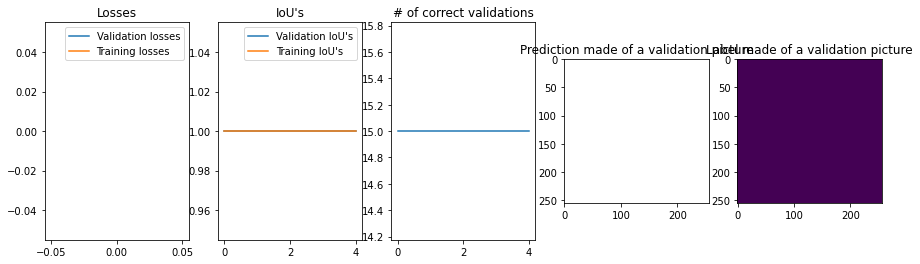

At epoch 4 Training loss is at nan and the IoU is at 1.0%
At epoch 4 Validation loss is at nan and the IoU is at 1.0%


In [32]:
# Define list to stor intermediat results
valid_iter = []
valid_loss = []
valid_iou = []
valid_correct = []

train_iter = []
train_loss = []
train_iou = []

DL_valid = DataLoader(DS_valid)

# Training loop
net.train()
for epoch in range(NUM_EPOCHS):

    print(f"train epoch {epoch}")
    # transform data and add it to the dataloader
    DS_train.transforms(p_rot=0.1,p_trans=0.1,p_zoom=0.1,p_shear=0.1)
    DL_train = DataLoader(DS_train, batch_size=16, shuffle=True)
    for i, data in enumerate(DL_train, 0):
        net.train()
        input = data[0].type(torch.FloatTensor)
        target = data[1].type(torch.FloatTensor)

        # Tranfer to GPU if possible
        input = get_variable(input)
        target = get_variable(target)

        # Train the network
        optimizer.zero_grad()
        output = net(input)
        loss = criterion(output,target)
        loss.backward()
        optimizer.step()

        # Save space
        del input
        del target
        del output
        del loss

    # If we want to evaluate
    if epoch % check_at == 0:
      net.eval()

      with torch.no_grad():
        # Evaluate training
        train_losses, train_ious, train_batches = 0, 0, 0
        for i, data in enumerate(DL_train, 0):
          input = data[0].type(torch.FloatTensor)
          target = data[1].type(torch.FloatTensor)

          # Tranfer to GPU if possible
          input = get_variable(input)
          target = get_variable(target)
          
          output = net(input)

          # Record performance
          train_batches += 1
          train_losses += criterion(output, target).item()
          train_ious += IoU_score(get_numpy(target), get_numpy(output))[0]

          # Save space
          del input
          del target
          del output

        train_iter.append(epoch)
        train_loss.append(train_losses / train_batches)
        train_iou.append(train_ious / train_batches)

        # Evaluate validation
        val_losses, val_ious, val_batches,n_correct = 0, 0, 0, 0
        once=True
        for i, valid_data in enumerate(DL_valid, 0):
            input = valid_data[0].type(torch.FloatTensor)
            target = valid_data[1].type(torch.FloatTensor)
            
            # Tranfer to GPU if possible
            input = get_variable(input)
            target = get_variable(target)
            
            output = net(input)
            if i>=np.random.randint(0,len(DS_valid)) and once:
            #   input1 = input
            #   output1 = output
              img = one_hot2_2d(get_numpy(output[0]))[0]
              img_label = one_hot2_2d(get_numpy(target[0]))[0]
              once = False
            
            # Record performance
            val_batches += 1
            val_losses += criterion(output, target).item()
            val_ious += IoU_score(get_numpy(target), get_numpy(output))[0]
            n_correct += IoU_score(get_numpy(target), get_numpy(output))[1]
            
            # Save space
            del input
            del target
            del output

        valid_iter.append(epoch)
        valid_loss.append(val_losses / val_batches)
        valid_iou.append(val_ious / val_batches)
        valid_correct.append(n_correct)
        clear_output(wait=True)
        fig = plt.figure(figsize=(15,4))
        plt.subplot(151)
        plt.plot(valid_iter,valid_loss,label='Validation losses')
        plt.plot(train_iter,train_loss,label='Training losses')
        plt.title('Losses')
        plt.legend()

        plt.subplot(152)
        plt.plot(valid_iter,valid_iou,label='Validation IoU\'s')
        plt.plot(train_iter,train_iou,label='Training IoU\'s')
        plt.title('IoU\'s')
        plt.legend()
        
        plt.subplot(153)
        plt.plot(valid_iter,valid_correct)
        plt.title('# of correct validations')

        plt.subplot(154)
        plt.imshow(img)
        plt.title('Prediction made of a validation picture')

        plt.subplot(155)
        plt.imshow(img_label)
        plt.title('Label made of a validation picture')
        plt.show()
        print(f'At epoch {epoch} Training loss is at {train_loss[-1]} and the IoU is at {train_iou[-1]}%')
        print(f'At epoch {epoch} Validation loss is at {valid_loss[-1]} and the IoU is at {valid_iou[-1]}%') 
    
    DS_train.remove_transforms()

In [33]:
torch.save(net,'poster_network.pickle')

(9, 256, 256) (256, 256) (1, 256, 256)


/usr/local/lib/python3.7/dist-packages/matplotlib/image.py:452: UserWarning: Warning: converting a masked element to nan.
  dv = np.float64(self.norm.vmax) - np.float64(self.norm.vmin)
/usr/local/lib/python3.7/dist-packages/matplotlib/image.py:459: UserWarning: Warning: converting a masked element to nan.
  a_min = np.float64(newmin)
/usr/local/lib/python3.7/dist-packages/matplotlib/image.py:464: UserWarning: Warning: converting a masked element to nan.
  a_max = np.float64(newmax)
<string>:6: UserWarning: Warning: converting a masked element to nan.
/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)


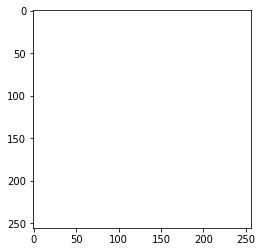

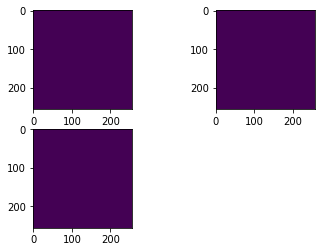

0 0.0


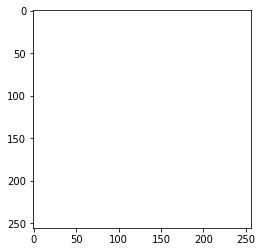

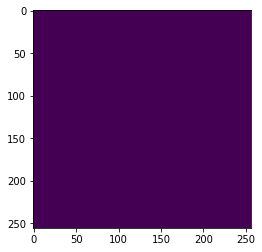

In [36]:
val_img = 3
print(DS_valid.labels[val_img].shape,one_hot2_2d(DS_valid.labels[val_img])[0].shape,DS_valid.data[val_img].shape)
# Target 
plotMaskOnImage(DS_valid.data[val_img,0],one_hot2_2d(DS_valid.labels[val_img])[0],0)

# Network output
output = np.squeeze(
            get_numpy(
                net(
                    get_variable(
                        torch.from_numpy(
                            DS_valid.data[val_img][np.newaxis, :, ::]
                            ).type(torch.cuda.FloatTensor)
                        )
                    )
                )
            )

output_2d = np.zeros((256, 256))

mistake_arr = np.zeros((256,256))
output_2d = np.argmax(output,axis=0)
plt.subplot(221)
plt.imshow(output_2d)

plt.subplot(222)
plt.imshow(one_hot2_2d(DS_valid.labels[val_img])[0])

plt.subplot(223)
plt.imshow(output_2d-one_hot2_2d(DS_valid.labels[val_img])[0])
plt.show()

print(np.amax(output_2d),np.amax(one_hot2_2d(DS_valid.labels[val_img])[0]))
plotMaskOnImage(
    DS_valid.data[val_img,0],
    output_2d,0)

plt.imshow(mistake_arr)
plt.show()

/usr/local/lib/python3.7/dist-packages/matplotlib/image.py:452: UserWarning: Warning: converting a masked element to nan.
  dv = np.float64(self.norm.vmax) - np.float64(self.norm.vmin)
/usr/local/lib/python3.7/dist-packages/matplotlib/image.py:459: UserWarning: Warning: converting a masked element to nan.
  a_min = np.float64(newmin)
/usr/local/lib/python3.7/dist-packages/matplotlib/image.py:464: UserWarning: Warning: converting a masked element to nan.
  a_max = np.float64(newmax)
<string>:6: UserWarning: Warning: converting a masked element to nan.
/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)


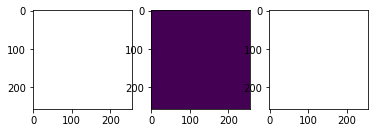

In [43]:
net.eval()
input = DS_train.data[1].reshape([1,1,256,256])
input = get_variable(torch.tensor(input).type(torch.FloatTensor))
output = net(input)

img_label = one_hot2_2d(get_numpy(output)[0])
img_pred = one_hot2_2d(DS_train.labels[1])

plt.subplot(131)
plt.imshow(img_label[0])

plt.subplot(132)
plt.imshow(img_pred[0])

plt.subplot(133)
plt.imshow(DS_train.data[1,0]-np.min(DS_train.data[1]))
plt.show()

# Test model

In [44]:
# Load in model
%%capture
net = torch.load('poster_network.pickle')
net = net.to(torch.float)
if use_cuda:
    print('converting network to cuda-enabled')
    net.cuda()

In [45]:
DS_test.remove_transforms()
DS_valid.remove_transforms()
DL_try = DataLoader(DS_valid)

dice = []
ioulst =[]
n_correct =[]
# trained_model.cuda()
for i,data in enumerate(DL_try):
  input = data[0].type(torch.FloatTensor)
  target = data[1].type(torch.FloatTensor)
  
  # Tranfer to GPU if possible
  input = get_variable(input)
  target = get_variable(target)
  
  output = net(input)
  dice.append(Dicecoeff(get_numpy(output),get_numpy(target)))
  ioulst.append(IoU_score(get_numpy(target),get_numpy(output),threshold=0.8)[0])
  n_correct.append(IoU_score(get_numpy(target),get_numpy(output),threshold=0.8)[1])
print('average Dice score:',np.mean(dice))
print('average IoU score:',np.mean(ioulst))
print(sum(n_correct),'out of ',len(n_correct))

print(ioulst)

print(confidenceinterval(np.array(ioulst)))
print(confidenceinterval(np.array(dice)))

average Dice score: 1.0
average IoU score: 1.0
15 out of  15
[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
(nan, nan)
(nan, nan)


/usr/local/lib/python3.7/dist-packages/scipy/stats/_distn_infrastructure.py:2003: RuntimeWarning: invalid value encountered in multiply
  lower_bound = _a * scale + loc
/usr/local/lib/python3.7/dist-packages/scipy/stats/_distn_infrastructure.py:2004: RuntimeWarning: invalid value encountered in multiply
  upper_bound = _b * scale + loc


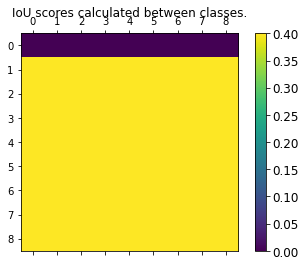

In [46]:
idx = 10
DS_valid.remove_transforms()
DL_valid = DataLoader(DS_valid)
iou_arr = np.zeros((20,9,9))
for idx, data in enumerate(DL_valid):
  if idx<20:
    input = data[0].type(torch.FloatTensor)
    target = data[1].type(torch.FloatTensor)
    target = get_numpy(target)[0]
    prediction = net(get_variable(input))
    prediction = get_numpy(prediction)[0]
    prediction = one_hot_encode(np.argmax(prediction,axis=0))[0]
    for i in range(9):
      for j in range(9):
        tar1 = np.zeros((1,2,256,256))
        pred1 = np.zeros((1,2,256,256))
        tar1[0,0],pred1[0,0] = target[i],prediction[i]
        tar1[0,1],pred1[0,0] = target[j],prediction[j]

        iou_arr[i,j] = IoU_score(tar1,pred1,special=True)[0]

# plt.matshow(np.average(iou_arr,axis=0),cmap='viridis')
fontsize = 12
# plot iou between classes
fig, ax = plt.subplots()
im = ax.matshow(np.average(iou_arr,axis=0),cmap='viridis')
cbar = plt.colorbar(im)
# cbar.set_label('correlation',fontsize)
cbar.ax.tick_params(labelsize=fontsize)
plt.title('IoU scores calculated between classes.',fontsize=fontsize)


plt.savefig("interclass_IoU.pdf", format="pdf", bbox_inches="tight")
plt.show()

/usr/local/lib/python3.7/dist-packages/matplotlib/image.py:452: UserWarning: Warning: converting a masked element to nan.
  dv = np.float64(self.norm.vmax) - np.float64(self.norm.vmin)
/usr/local/lib/python3.7/dist-packages/matplotlib/image.py:459: UserWarning: Warning: converting a masked element to nan.
  a_min = np.float64(newmin)
/usr/local/lib/python3.7/dist-packages/matplotlib/image.py:464: UserWarning: Warning: converting a masked element to nan.
  a_max = np.float64(newmax)
<string>:6: UserWarning: Warning: converting a masked element to nan.
/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)


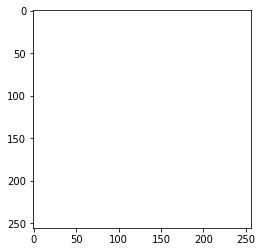

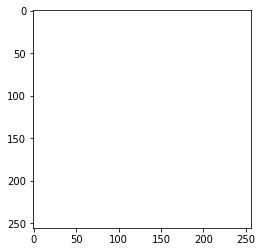

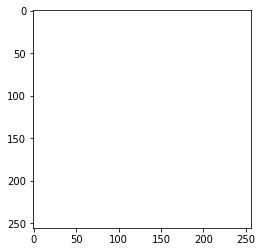

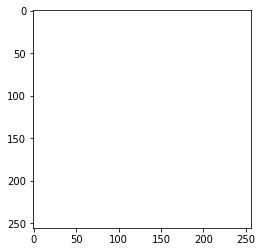

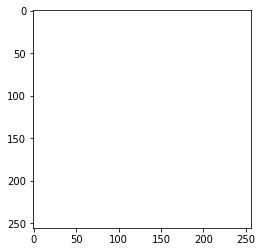

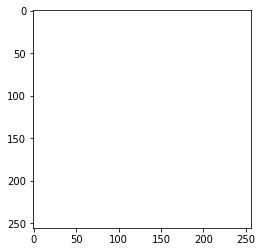

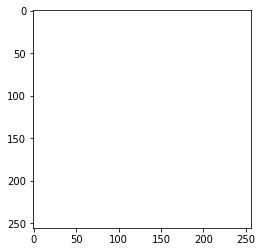

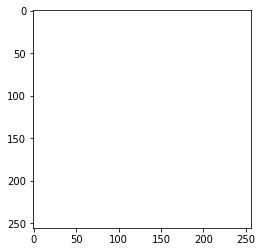

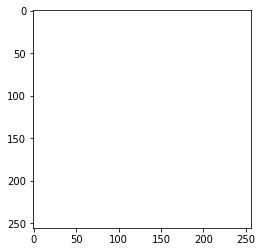

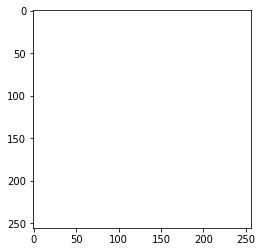

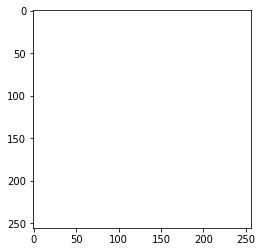

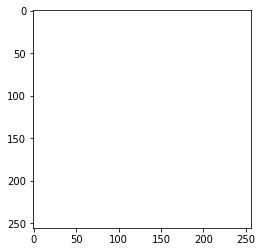

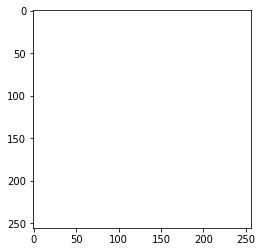

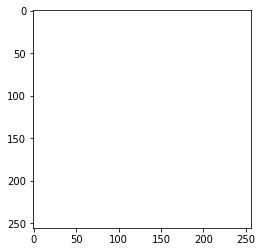

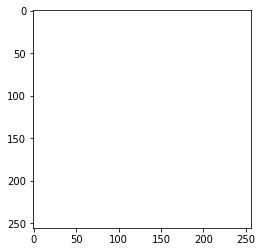

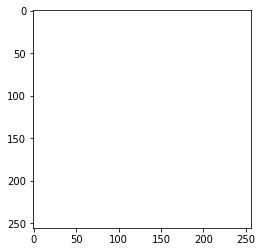

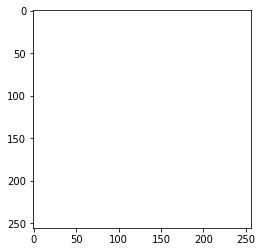

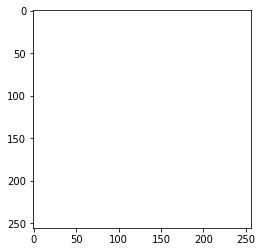

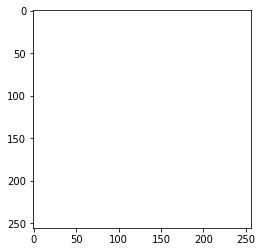

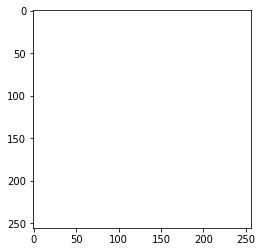

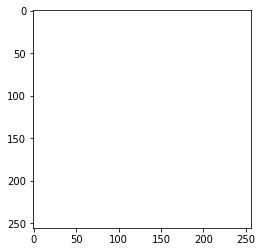

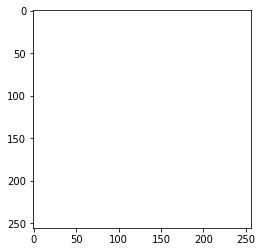

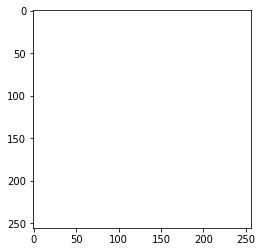

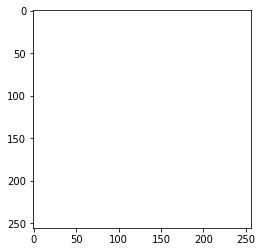

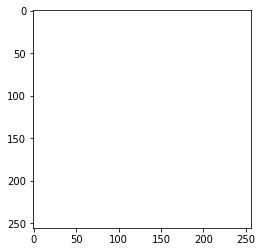

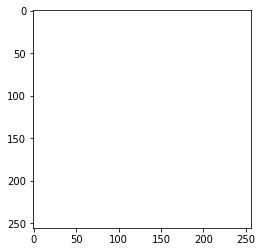

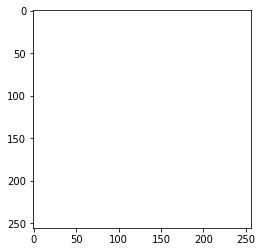

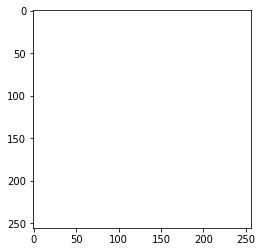

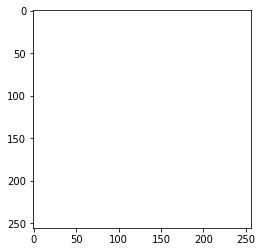

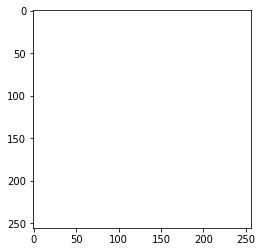

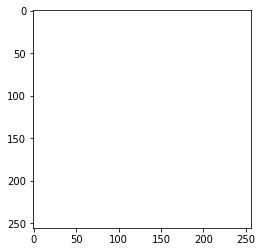

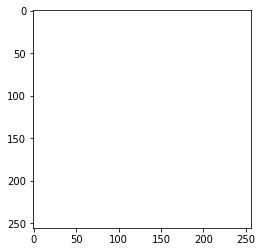

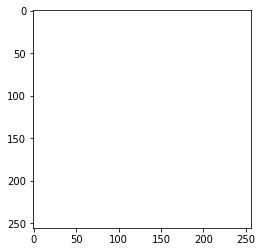

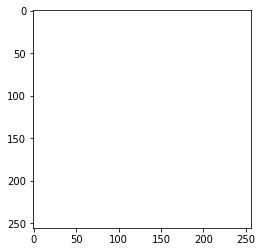

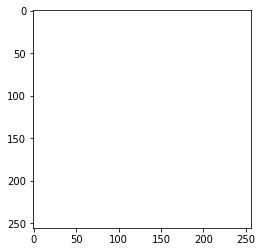

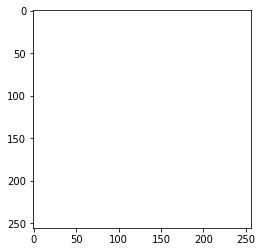

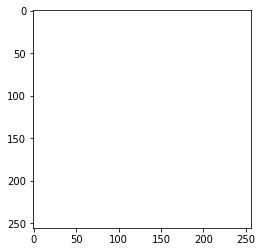

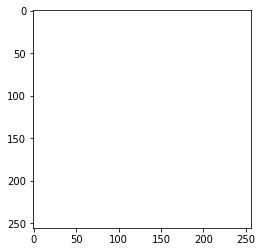

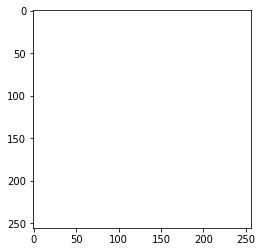

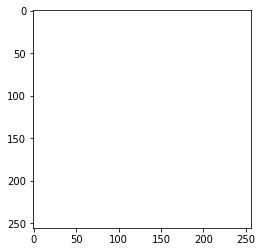

0.0 0


In [47]:
for i in range(20):
  idx = i
  DS_test.remove_transforms()
  img = DS_test.data[idx,0]
  mask1 = one_hot2_2d(DS_test.labels[idx])[0]


  prediction = net(get_variable(torch.tensor(DS_test.data[idx].reshape(1,1,256,256)).type(torch.FloatTensor)))
  mask2 = np.argmax(get_numpy(prediction)[0],axis=0)
  mask1[0,0] = np.amax(mask2)
  plotMaskOnImage(img,mask1,0,add_name=f'true{idx}')
  plotMaskOnImage(img,mask2,0,add_name=f'pred{idx}')

print(np.amax(mask1),np.amax(mask2))